In [3]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import intake
import healpix
import easygems.healpix as egh

import tobac

In [5]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/online.yaml")

pd.DataFrame(cat.ICON.ngc4008.describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT15M, PT3H, P1D]",P1D
1,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",0


In [6]:
zoom = 7
grid_spacing = 64 / 2**zoom
dxy = 1e5 * grid_spacing

In [7]:
icon_ds = cat.ICON.ngc4008(
    zoom=zoom, time="PT15M", chunks={}
).to_dask().pipe(egh.attach_coords)

/home/markmuetz/anaconda3/envs/hackathon_env/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [13]:
icon_ds.lat.min()

<xarray.DataArray 'lat' ()> Size: 8B
array(-89.6345165)
Coordinates:
    crs      int64 8B 0

In [16]:
def latlon_remap_cells(grid_spacing, healpix_nside):
    lon = xr.DataArray(
        np.arange(-180 + grid_spacing/2, 180, grid_spacing),
        dims=("lon",), 
        name="lon", 
        attrs=dict(units="degrees", standard_name="longitude")
    )
    lat = xr.DataArray(
        np.arange(-90 + grid_spacing/2, 90, grid_spacing), 
        dims=("lat",), 
        name="lat", 
        attrs=dict(units="degrees", standard_name="latitude")
    )

    return xr.DataArray(
        healpix.ang2pix(healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
        coords=(lat, lon),
    )

In [17]:
pix = latlon_remap_cells(0.5, 2**zoom)

In [18]:
pix

<xarray.DataArray (lat: 360, lon: 720)> Size: 2MB
array([[163840, 163840, 163840, ..., 147456, 147456, 147456],
       [163848, 163848, 163848, ..., 147460, 147460, 147460],
       [163850, 163850, 163850, ..., 147461, 147461, 147461],
       ...,
       [ 49146,  49146,  49146, ...,  32757,  32757,  32757],
       [ 49147,  49147,  49147, ...,  32759,  32759,  32759],
       [ 49151,  49151,  49151, ...,  32767,  32767,  32767]])
Coordinates:
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

In [19]:
ds = xr.open_dataset('/home/markmuetz/Datasets/hackathon/tmp/glm.n1280_GAL9_nest.apvera_20200120T00.air_temperature.0.nc')

/tmp/ipykernel_9927/1911905771.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/home/markmuetz/Datasets/hackathon/tmp/glm.n1280_GAL9_nest.apvera_20200120T00.air_temperature.0.nc')


In [20]:
ds

<xarray.Dataset> Size: 20MB
Dimensions:                  (time: 1, latitude: 1920, longitude: 2560)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2020-01-20T00:04:00
  * latitude                 (latitude) float32 8kB -89.95 -89.86 ... 89.95
  * longitude                (longitude) float32 10kB 0.07031 0.2109 ... 359.9
    forecast_period          (time) timedelta64[ns] 8B ...
    forecast_reference_time  datetime64[ns] 8B ...
    height                   float64 8B ...
Data variables:
    air_temperature          (time, latitude, longitude) float32 20MB ...
    latitude_longitude       int32 4B ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   13.5
    Conventions:  CF-1.7

In [39]:
cells = np.arange(12 *  4**zoom)
remap_lons, remap_lats = healpix.pix2ang(
    2**zoom, cells, nest=True, lonlat=True,
)

# Get lons in range [-180, 180]
remap_lons = remap_lons % 360
remap_lons = np.where(remap_lons < 180, remap_lons, remap_lons - 360)

In [40]:
# get lats in range [-60, 60] and mask all arrays accordingly
mask = (remap_lats > -60) & (remap_lats < 60)
mcells = cells[mask]
mremap_lons = remap_lons[mask]
mremap_lats = remap_lats[mask]

In [41]:
ds_hp = ds.sel(
    longitude=xr.DataArray(mremap_lons, dims="cell", coords={"cell":mcells}), 
    latitude=xr.DataArray(mremap_lats, dims="cell", coords={"cell":mcells}), 
    method="nearest"
).drop_vars(['longitude', 'latitude']).compute()

/tmp/ipykernel_9927/1673687960.py:5: SerializationWarning: Can't decode floating point timedelta to 's' without precision loss, decoding to 'ns' instead. To silence this warning use time_unit='ns' in call to decoding function.
  ).drop_vars(['longitude', 'latitude']).compute()


In [42]:
ds_hp

<xarray.Dataset> Size: 2MB
Dimensions:                  (time: 1, cell: 170040)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2020-01-20T00:04:00
    forecast_period          (time) timedelta64[ns] 8B 00:03:59.999999944
    forecast_reference_time  datetime64[ns] 8B 2020-01-20
    height                   float64 8B 1.5
  * cell                     (cell) int64 1MB 0 1 2 3 ... 196605 196606 196607
Data variables:
    air_temperature          (time, cell) float32 680kB 299.8 299.7 ... 300.6
    latitude_longitude       int32 4B -2147483647
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   13.5
    Conventions:  CF-1.7

<Figure size 640x480 with 0 Axes>

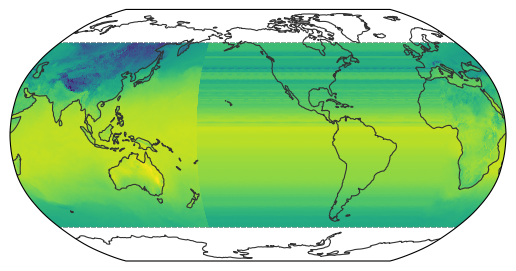

In [44]:
crs = xr.DataArray(
    name="crs",
    attrs={
        "grid_mapping_name": "healpix",
        "healpix_nside": 2**zoom,
        "healpix_order": "nest",
    },
)
ds_hp = ds_hp.assign_coords(crs=crs)

egh.healpix_show(ds_hp.air_temperature.isel(time=0))

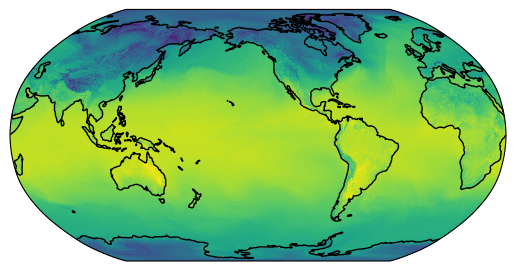

In [35]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=-137)})
ax.pcolormesh(ds.longitude, ds.latitude, ds.air_temperature.isel(time=0), transform=ccrs.PlateCarree())
ax.coastlines()